<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/SellBuyHoldPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [1]:
%tensorflow_version 1.x
!pip install ta
!pip uninstall pandas-datareader
!pip install pandas-datareader

  Created wheel for ta: filename=ta-0.5.11-cp36-none-any.whl size=23031 sha256=21b4d44fc3f95e6d4141d4b0ce33cc2d44fc7ef544b6f4dbf36e46f073d6b885
  Stored in directory: /root/.cache/pip/wheels/97/32/1d/cbc724a8ecaec6e426baf57ab8c4c2cdc687aadd7427280b1f
Successfully built ta
Uninstalling pandas-datareader-0.7.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas_datareader-0.7.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas_datareader/*
Proceed (y/n)? y
  Successfully uninstalled pandas-datareader-0.7.4
     |████████████████████████████████| 112kB 3.5MB/s 


## Import Libraray

In [0]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import os
from operator import itemgetter

import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score, f1_score

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import pandas_datareader.data  as pdr
from tqdm.auto import tqdm

from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

register_matplotlib_converters()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]


## Parameters

In [0]:
total_years = 20
total_dates = total_years * 365
intervals = range(6, 27)  # 21

In [0]:
ticker = 'IBM' #@param ["GOOG", "IBM", "MSFT", "AAPL"]
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())

## Technical Indicators

In [0]:
def calculate_RSI(data, intervals):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """
    print("Calculating RSI")
    for i in tqdm(intervals):
        delta = data['Close'] - data['Close'].shift(1)
        gain = (delta > 0) * delta
        loss = (delta < 0) * -delta
        avg_gain = gain.rolling(i).sum() / i
        avg_loss = loss.rolling(i).sum() / i
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        data['rsi_' + str(i)] = rsi

def calcualte_IBR(data):
    return (data['Close'] - data['Low']) / (data['High'] - data['Low'])

def calculate_WilliamR(data, intervals):
    """
    Momentum indicator
    Using TA Libraray
    %R = (Highest High - Close)/(Highest High - Lowest Low) * -100
    """
    print("Calculating WilliamR")
    for i in tqdm(intervals):
        data['wr_' + str(i)] = wr(data['High'], data['Low'], data['Close'], i, fillna=True)

def calculate_MFI(df, intervals):
    """
    Momentum type indicator
    """
    print("Calculating MFI")
    for i in tqdm(intervals):
        df['mfi_' + str(i)] = money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], n=i, fillna=True)

def calculate_roc(series, period):
    return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

def calculate_ROC(data, intervals):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    print("Calculating ROC")
    for period in tqdm(intervals):
        data['roc_' + str(period)] = np.nan
        # for 12 day period, 13th day price - 1st day price
        res = data['Close'].rolling(period + 1).apply(calculate_roc, args=(period,), raw=False)
        data['roc_' + str(period)] = res

def calculate_CMF(data, intervals):
    """
    An oscillator type indicator & volume type
    No other implementation found
    """
    print("Calculating CMF")
    for i in tqdm(intervals):
        data['cmf_' + str(i)] = chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'], i, fillna=True)

def calculate_cmo(series, period):
    # num_gains = (series >= 0).sum()
    # num_losses = (series < 0).sum()
    sum_gains = series[series >= 0].sum()
    sum_losses = np.abs(series[series < 0].sum())
    cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
    return np.round(cmo, 3)

def calculate_CMO(data, intervals):
    """
    Chande Momentum Oscillator
    As per https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    diff = data["Close"].diff()[1:]  # skip na
    print("Calculating CMO")
    for period in tqdm(intervals):
        data['cmo_' + str(period)] = np.nan
        res = diff.rolling(period).apply(calculate_cmo, args=(period,), raw=False)
        data['cmo_' + str(period)][1:] = res

def calculate_SMA(data, intervals, col_name = 'Close'):
    """
    Momentum indicator
    """
    print("Calculating SMA " + col_name)
    for i in tqdm(intervals):
        data[col_name + '_sma_' + str(i)] = data[col_name].rolling(i).mean()

def calculate_EMA(data, intervals):
    """
    Momentum indicator
    """
    print("Calculating EMA")
    for i in tqdm(intervals):
        data['ema_' + str(i)] = data['Close'].ewm(span=i, min_periods=i-1).mean()

def wavg(rolling_prices, period):
    weights = pd.Series(range(1, period + 1))
    return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

def calculate_WMA(data, intervals, hma_step=0):
    """
    Momentum indicator
    """
    if (hma_step == 0):
        print("Calculating WMA")

    temp_col_count_dict = {}
    for i in tqdm(intervals, disable=(hma_step != 0)):
        res = data['Close'].rolling(i).apply(wavg, args=(i,), raw=False)
        # print("interval {} has unique values {}".format(i, res.unique()))
        if hma_step == 0:
            data['wma_' + str(i)] = res
        elif hma_step == 1:
            if 'hma_wma_' + str(i) in temp_col_count_dict.keys():
                temp_col_count_dict['hma_wma_' + str(i)] = temp_col_count_dict['hma_wma_' + str(i)] + 1
            else:
                temp_col_count_dict['hma_wma_' + str(i)] = 0
                # after halving the periods and rounding, there may be two intervals with same value e.g.
                # 2.6 & 2.8 both would lead to same value (3) after rounding. So save as diff columns
                df['hma_wma_' + str(i) + '_' + str(temp_col_count_dict['hma_wma_' + str(i)])] = 2 * res
        elif hma_step == 3:
            import re
            expr = r"^hma_[0-9]{1}"
            columns = list(df.columns)
            # print("searching", expr, "in", columns, "res=", list(filter(re.compile(expr).search, columns)))
            data['hma_' + str(len(list(filter(re.compile(expr).search, columns))))] = res

def calculate_TRIX(data, intervals):
    """
    Shows the percent rate of change of a triple exponentially smoothed moving average.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:trix
    TA lib actually calculates percent rate of change of a triple exponentially
    smoothed moving average not Triple EMA.
    Momentum indicator
    Need validation!
    """
    print("Calculating TRIX")
    for i in tqdm(intervals):
        data['trix_' + str(i)] = trix(data['Close'], i, fillna=True)

def calculate_CCI(data, intervals):
    """
    Commodity Channel Index (CCI)
    CCI measures the difference between a security’s price change and its average 
    price change. High positive readings indicate that prices are well above their 
    average, which is a show of strength. Low negative readings indicate that 
    prices are well below their average, which is a show of weakness.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    """
    print("Calculating CCI")
    for i in tqdm(intervals):
        data['cci_' + str(i)] = cci(data['High'], data['Low'], data['Close'], i, fillna=True)

def calculate_DPO(data, intervals):
    """
    Detrended Price Oscillator (DPO)
    Is an indicator designed to remove trend from price and make it easier to 
    identify cycles.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:detrended_price_osci    
    """
    print("Calculating DPO")
    for i in tqdm(intervals):
        data['dpo_' + str(i)] = dpo(data['Close'], n=i)

def calculate_KST(data, intervals):
    """
    KST Oscillator (KST Signal)
    It is useful to identify major stock market cycle junctures because its 
    formula is weighed to be more greatly influenced by the longer and more 
    dominant time spans, in order to better reflect the primary swings of stock 
    market cycle.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:know_sure_thing_kst  """
    print("Calculating KST")
    for i in tqdm(intervals):
        data['kst_' + str(i)] = kst(data['Close'], i)

def calculate_DMI(data, intervals):
    """
    Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI) are 
    derived from smoothed averages of these differences, and measure trend direction 
    over time. These two indicators are often referred to collectively as the 
    Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed 
    averages of the difference between +DI and -DI, and measures the strength 
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the 
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    """
    print("Calculating DMI")
    for i in tqdm(intervals):
        data['dmi_'+str(i)] = adx(data['High'], data['Low'], data['Close'], n=i, fillna=True)

def calculate_BB_MAV(data, intervals):
    """
    Bollinger Bands (BB)
    N-period simple moving average (MA).
    https://en.wikipedia.org/wiki/Bollinger_Bands
    """
    print("Calculating Bollinger Band MAV")
    for i in tqdm(intervals):
        data['bb_' + str(i)] = bollinger_mavg(data['Close'], n=i, fillna=True)

def calculate_FI(data, intervals):
    """
    Force Index (FI)
    It illustrates how strong the actual buying or selling pressure is. 
    High positive values mean there is a strong rising trend, and low 
    values signify a strong downward trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:force_index
    """
    print("Calculating Force Index")
    for i in tqdm(intervals):
        data['fi_' + str(i)] = force_index(data['Close'], data['Volume'], n=i, fillna=True)

def calculate_EOM(ohlc, ndays=20):
    """
    An Oscillator type indicator and volume type
    Ease of Movement : https://www.investopedia.com/terms/e/easeofmovement.asp
    """
    print("Calculating EOM")
    dm = (data['High'] + data['Low']) / 2 - (data['High'].shift(1) - data['Low'].shift(1)) / 2
    br = data['Volume'] / (data['High'] - data['Low'])
    evm = dm / br
    for i in tqdm(intervals):
        data['eom_' + str(i)] = evm.rolling(i).mean()

In [0]:
def calculate_technical_indicators(data, intervals):
  # Momentum Indicators
  calculate_RSI(data, intervals)
  calculate_WilliamR(data, intervals)
  calculate_MFI(data, intervals)
  
  # calculate_MACD(data, intervals)  # ready to use +3
  # calculate_PPO(data, intervals)  #ready to use +1
  calculate_ROC(data, intervals)  # Took long
  calculate_CMF(data, intervals)  # volume EMA
  calculate_CMO(data, intervals)  # Took long
  calculate_SMA(data, intervals)
  calculate_SMA(data, intervals, 'Open')
  calculate_EMA(data, intervals)
  calculate_WMA(data, intervals)
  """
  calculate_HMA(data, intervals)
  """
  # Trending 
  calculate_TRIX(data, intervals)
  calculate_CCI(data, intervals)
  calculate_DPO(data, intervals)  # Trend oscillator
  calculate_KST(data, intervals)
  calculate_DMI(data, intervals) 
  # volatility
  calculate_BB_MAV(data, intervals)
  # calculate_PSI(data, intervals)  # can't find formula
  calculate_FI(data, intervals)  # volume
  calculate_EOM(data, intervals)


In [9]:
calculate_technical_indicators(data, intervals)
data.dropna(inplace=True)

Calculating RSI



Calculating WilliamR



Calculating MFI



Calculating ROC



Calculating CMF



Calculating CMO



Calculating SMA Close



Calculating SMA Open



Calculating EMA



Calculating WMA



Calculating TRIX



Calculating CCI



Calculating DPO



Calculating KST



Calculating DMI


/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])



Calculating Bollinger Band MAV



Calculating Force Index



Calculating EOM


## Create Label

In [0]:
def create_labels(data, window_size=11):
  """
  Data is labeled as per the logic in research paper
  Label code : BUY => 1, SELL => 0, HOLD => 2
  params :
      df => Dataframe with data
      col_name => name of column which should be used to determine strategy
  returns : numpy array with integer codes for labels with
            size = total-(window_size)+1
  """
  BUY = 1
  SELL = 0
  HOLD = 2
  row_counter = 0
  total_rows = len(data)
  labels = np.zeros(total_rows)
  labels[:] = np.nan
  print("Calculating labels")
  pbar = tqdm(total_rows)

  while row_counter < total_rows:
    if row_counter >= window_size - 1:
      window_begin = row_counter - (window_size - 1)
      window_end = row_counter
      window_middle = (window_begin + window_end) / 2

      min_price = np.inf
      min_index = -1
      max_price = -np.inf
      max_index = -1
      for i in range(window_begin, window_end + 1):
        price = data.iloc[i]['Close']
        if price < min_price:
          min_price = price
          min_index = i
        if price > max_price:
          max_price = price
          max_index = i

      if max_index == window_middle:
        labels[row_counter] = SELL
      elif min_index == window_middle:
        labels[row_counter] = BUY
      else:
        labels[row_counter] = HOLD

    row_counter = row_counter + 1
    pbar.update(1)

  pbar.close()
  return labels


In [10]:
labels = create_labels(data)
data['labels'] = labels
data.dropna(inplace=True)

Calculating labels


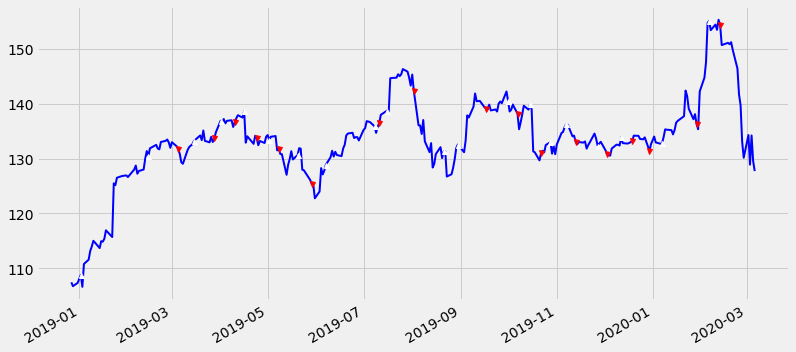

In [11]:
plt_data = data[-300:]
fig, ax1 = plt.subplots()
plt.plot(plt_data['Adj Close'].index, plt_data['Adj Close'], 'b-', linewidth=2) 

# Plot the buy signals
ax1.plot(plt_data.loc[plt_data.labels == 1].index, 
         plt_data['Adj Close'][plt_data.labels == 1],
         '^', markersize=5, color='w')

# Plot the sell signals
ax1.plot(plt_data.loc[plt_data.labels == 0].index, 
         plt_data['Adj Close'][plt_data.labels == 0],
         'v', markersize=5, color='r')
fig.autofmt_xdate()


## Select Best Feature

In [0]:
start_col='Open'
end_col='eom_26'

In [0]:
def select_features(data, num_features=225, topK=350, start_col='Open', end_col='eom_26'):
    """
    num_features should be a perfect square
    """
    data_batch = data.copy()
    list_features = list(data_batch.loc[:, start_col:end_col].columns)
    mm_scaler = MinMaxScaler(feature_range=(0, 1))  # or StandardScaler?
    x_train = mm_scaler.fit_transform(data_batch.loc[:, start_col:end_col].values)
    y_train = data_batch['labels'].values
    
    select_k_best = SelectKBest(f_classif, k=topK)
    select_k_best.fit(x_train, y_train)
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

    select_k_best = SelectKBest(mutual_info_classif, k=topK)
    select_k_best.fit(x_train, y_train)
    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

    common = list(set(selected_features_anova).intersection(selected_features_mic))
    if len(common) < num_features:
        raise Exception(
            'number of common features found {} < {} required features. Increase "topK"'.format(len(common), num_features))
                 
    printable_features = "\n".join(["\t".join(common[i:i + 10]) for i in range(0, len(common), 10)])

    print("common selected featues:\n{}".format(printable_features))
                                                                             
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:num_features])
    return feat_idx
 

In [14]:
feature_idx = select_features(data)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


common selected featues:
wma_23	cci_23	roc_10	Open_sma_18	wma_15	cci_22	dpo_13	wr_9	ema_19	dpo_23
dmi_15	bb_7	roc_13	trix_25	dpo_12	wr_25	dmi_7	wma_13	roc_17	kst_16
eom_12	rsi_25	Open_sma_10	dmi_19	trix_19	bb_6	fi_17	trix_7	fi_20	dpo_11
kst_8	fi_10	fi_21	rsi_12	fi_12	wr_24	ema_18	cci_11	cmo_15	kst_17
dpo_20	cci_9	cci_6	dmi_20	roc_22	fi_24	bb_15	wma_14	bb_10	dpo_16
dpo_9	wma_6	dmi_24	rsi_10	wma_9	Close_sma_18	trix_12	rsi_16	bb_11	trix_20
bb_14	ema_6	cci_21	wr_23	rsi_7	cci_12	rsi_8	eom_13	cci_19	fi_23
trix_8	cmo_11	dmi_6	mfi_6	Open_sma_19	ema_9	wma_19	bb_9	dmi_16	rsi_24
cci_24	fi_19	trix_11	kst_10	wr_20	roc_18	cci_20	kst_6	fi_13	kst_9
cmf_7	cmf_16	trix_24	cmf_15	wma_16	roc_8	cmf_12	wr_18	kst_13	cmf_26
kst_18	ema_20	cmo_26	kst_23	bb_19	cci_8	ema_11	cmo_17	Close_sma_15	cmo_12
roc_9	rsi_15	Close_sma_12	Close_sma_13	ema_10	cci_18	rsi_21	ema_25	fi_16	dpo_21
trix_15	dpo_17	cmo_6	wma_24	wr_13	cmo_16	wma_20	dmi_18	cmf_6	Close_sma_19
trix_23	bb_17	rsi_13	dpo_25	dmi_22	dpo_26	cci_14	wr_22	kst_21	f

In [15]:
one_hot_enc = OneHotEncoder(sparse=False, categories='auto')
one_hot_enc.fit(data['labels'].values.reshape(-1, 1))     

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

## Create Model

### Create Metrics

In [0]:
 def get_precision(i, conf_mat):
    print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
    precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
    recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
    tf.add(i, 1)
    return i, conf_mat, precision, recall

def tf_count(i):
    elements_equal_to_value = tf.equal(y_true_class, i)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    class_counts[i].assign(count)
    tf.add(i, 1)
    return count

def condition(i, conf_mat):
    return tf.less(i, 3)

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(tf.math.multiply(f1s, weights))
    return weighted_f1

def calculate_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def calculate_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall
    """

    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [0]:
def check_baseline(pred, y_test):
    e = np.equal(pred, y_test)
    print("TP class counts", np.unique(y_test[e], return_counts=True))
    print("True class counts", np.unique(y_test, return_counts=True))
    print("Pred class counts", np.unique(pred, return_counts=True))
    holds = np.unique(y_test, return_counts=True)[1][2]  # number 'hold' predictions
    print("baseline acc:", str((holds / len(y_test) * 100)))

### Create CNN Model

In [0]:
get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

params = {'batch_size': 60, 
          'conv2d_layers': {'conv2d_do_1': 0.0, 
                            'conv2d_filters_1': 30,
                            'conv2d_kernel_size_1': 2, 
                            'conv2d_mp_1': 2, 
                            'conv2d_strides_1': 1,
                            'kernel_regularizer_1':0.0, 
                            'conv2d_do_2': 0.01, 
                            'conv2d_filters_2': 10,
                            'conv2d_kernel_size_2': 2, 
                            'conv2d_mp_2': 2, 
                            'conv2d_strides_2': 2,
                            'kernel_regularizer_2':0.0, 
                            'layers': 'two'},
          'dense_layers': {'dense_do_1': 0.07, 
                            'dense_nodes_1': 100, 
                            'kernel_regularizer_1':0.0, 
                            'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam', 
          'input_dim_1': 15, 
          'input_dim_2': 15, 
          'input_dim_3': 3}

In [0]:
def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    # (batch_size, timesteps, data_dim)
    # x_train, y_train = get_data_cnn(df, df.head(1).iloc[0]["timestamp"])[0:2]
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]),
                           padding='valid', activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(params['input_dim_1'],
                                        params['input_dim_2'], params['input_dim_3']))
    model.add(conv2d_layer1)

    if params["conv2d_layers"]['conv2d_mp_1'] == 1:
        model.add(MaxPool2D(pool_size=2))

    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))

    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='valid', activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        if params["conv2d_layers"]['conv2d_mp_2'] == 1:
            model.add(MaxPool2D(pool_size=2))
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))

    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu',
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))

    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    # from keras.utils.vis_utils import plot_model use this too for diagram with plot
    model.summary(print_fn=lambda x: print(x + '\n'))
    return model


In [20]:
model = create_model_cnn(params)
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1,
                   patience=100, 
                   min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.02, 
                        patience=10, 
                        verbose=1, 
                        mode='min',
                        min_delta=0.001, 
                        cooldown=1, 
                        min_lr=0.0001)
mcp = ModelCheckpoint("test", 
                      monitor='val_loss', 
                      verbose=0,
                      save_best_only=False, 
                      save_weights_only=False, 
                      mode='min', 
                      save_freq=1)


Training with params {'batch_size': 60, 'conv2d_layers': {'conv2d_do_1': 0.0, 'conv2d_filters_1': 30, 'conv2d_kernel_size_1': 2, 'conv2d_mp_1': 2, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.01, 'conv2d_filters_2': 10, 'conv2d_kernel_size_2': 2, 'conv2d_mp_2': 2, 'conv2d_strides_2': 2, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.07, 'dense_nodes_1': 100, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam', 'input_dim_1': 15, 'input_dim_2': 15, 'input_dim_3': 3}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d (Conv2D)              (None, 14, 14, 30)        390       

_________________________________________________________________

dropout (Dropout)            (None, 14, 14, 30)        0  

## Train Model

In [0]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

In [0]:
def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.
    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight('balanced', np.unique(y), y)

    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  

    return sample_weights

In [0]:
def prepare_data(data):
    list_features = list(data.loc[:, start_col:end_col].columns)
    print('Total number of features', len(list_features))
    x_train, x_test, y_train, y_test = \
    train_test_split(data.loc[:, start_col:end_col].values, 
                    data['labels'].values, 
                    train_size=0.8, 
                    test_size=0.2, 
                    random_state=2, 
                    shuffle=True, 
                    stratify=data['labels'].values)

    if 0.7*x_train.shape[0] < 2500:
        train_split = 0.8
    else:
        train_split = 0.7
    # train_split = 0.7
    print('train_split =', train_split)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    x_train, x_cv, y_train, y_cv = \
    train_test_split(x_train,
                    y_train, 
                    train_size=train_split, 
                    test_size=1-train_split, 
                    random_state=2, 
                    shuffle=True, 
                    stratify=y_train)
    mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
    x_train = mm_scaler.fit_transform(x_train)
    x_cv = mm_scaler.transform(x_cv)
    x_test = mm_scaler.transform(x_test)

    x_train = x_train[:, feature_idx]
    x_cv = x_cv[:, feature_idx]
    x_test = x_test[:, feature_idx]
    x_main = x_train.copy()
    print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))
    _labels, _counts = np.unique(y_train, return_counts=True)
    print("percentage of\n\tclass 0 = {}\n\tclass 1 = {}\n\tclass 2 = {}".format(
        _counts[0]/len(y_train) * 100, 
        _counts[1]/len(y_train) * 100, 
        _counts[2]/len(y_train) * 100))    
    return x_test, y_test, x_cv, y_cv, x_train, y_train


In [24]:
x_test, y_test, x_cv, y_cv, x_train, y_train = prepare_data(data)

Total number of features 383
train_split = 0.7
Shape of x, y train/cv/test (2788, 225) (2788,) (1195, 225) (1195,) (997, 225) (997,)
percentage of
	class 0 = 6.312769010043041
	class 1 = 6.1334289813486365
	class 2 = 87.55380200860832


In [25]:
sample_weights = get_sample_weights(y_train)

real class weights are [5.28030303 5.43469786 0.38071828] [0 1 2]
value_counts (array([0, 1, 2]), array([ 176,  171, 2441]))


In [0]:
one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  # , categories='auto'
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

In [27]:
dim = int(np.sqrt(x_train.shape[1]))
x_data = [np.stack((reshape_as_image(x, dim, dim),) * 3 , axis=-1) for x in [x_train, x_cv, x_test]]
x_train = x_data[0]
x_cv = x_data[1]
x_test = x_data[2]
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (2788, 15, 15, 3) (2788, 3) (997, 15, 15, 3) (997, 3)


In [28]:
%%time
history = model.fit(x_train, 
                    y_train, 
                    epochs=params['epochs'], 
                    verbose=1,
                    batch_size=64, 
                    shuffle=True,
                    # validation_split=0.3,
                    validation_data=(x_cv, y_cv),
                    callbacks=[mcp, rlp, es],
                    sample_weight=sample_weights)

Train on 2788 samples, validate on 1195 samples
Epoch 1/3000
2788/2788 [==============================] - 2s 600us/sample - loss: 1.0912 - acc: 0.3928 - f1_metric: 0.0000e+00 - val_loss: 1.0420 - val_acc: 0.4720 - val_f1_metric: 0.0000e+00
Epoch 2/3000
2788/2788 [==============================] - 1s 416us/sample - loss: 0.9686 - acc: 0.2823 - f1_metric: 0.0464 - val_loss: 0.9501 - val_acc: 0.3690 - val_f1_metric: 0.1399
Epoch 3/3000
2788/2788 [==============================] - 1s 411us/sample - loss: 0.8420 - acc: 0.3393 - f1_metric: 0.2009 - val_loss: 1.0022 - val_acc: 0.3556 - val_f1_metric: 0.1880
Epoch 4/3000
2788/2788 [==============================] - 1s 520us/sample - loss: 0.7457 - acc: 0.4369 - f1_metric: 0.3353 - val_loss: 1.0026 - val_acc: 0.3958 - val_f1_metric: 0.3035
Epoch 5/3000
2788/2788 [==============================] - 1s 420us/sample - loss: 0.6511 - acc: 0.4996 - f1_metric: 0.4340 - val_loss: 1.2802 - val_acc: 0.2962 - val_f1_metric: 0.2251
Epoch 6/3000
2788/2788 [

## Evalute Model

In [29]:
model = load_model("test")
test_res = model.evaluate(x_test, y_test, verbose=0)
print("keras evaluate=", test_res)

pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
check_baseline(pred_classes, y_test_classes)
conf_mat = confusion_matrix(y_test_classes, pred_classes)
print(conf_mat)

labels = [0,1,2]
# ax = sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
# ax.xaxis.set_ticks_position('top')
f1_weighted = f1_score(y_test_classes, pred_classes, labels=None, 
         average='weighted', sample_weight=None)
print("F1 score (weighted)", f1_weighted)
print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='micro', sample_weight=None))  
print("cohen's Kappa", cohen_kappa_score(y_test_classes, pred_classes))

prec = []
for i, row in enumerate(conf_mat):
    prec.append(np.round(row[i]/np.sum(row), 2))
    print("precision of class {} = {}".format(i, prec[i]))
print("precision avg", sum(prec)/len(prec))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
keras evaluate= [0.3796938332834598, 0.85757273, 0.8560546]
TP class counts (array([0, 1, 2]), array([ 51,  53, 751]))
True class counts (array([0, 1, 2]), array([ 63,  61, 873]))
Pred class counts (array([0, 1, 2]), array([104, 122, 771]))
baseline acc: 87.56268806419257
[[ 51   0  12]
 [  0  53   8]
 [ 53  69 751]]
F1 score (weighted) 0.8740293538219156
F1 score (macro) 0.7012129066425402
F1 score (micro) 0.8575727181544633
cohen's Kappa 0.5387447382482113
precision of class 0 = 0.81
precision of class 1 = 0.87
precision of class 2 = 0.86
precision avg 0.8466666666666667
